**Intro**

My first attempt at a Kaggle competition. Gets a reasonable score but would love some feedback on how it could be improved.

**Import everything**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, BayesianRidge
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error
# from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
# from scipy.special import boxcox1p, inv_boxcox1p

%matplotlib inline

**Read CSV file**

In [2]:
df_initial_train = pd.read_csv('train.csv')
df_train = df_initial_train.copy()


In [3]:
df_initial_test = pd.read_csv('test.csv')
df_test = df_initial_test.copy()
df_train = pd.concat([df_train, df_test], ignore_index=True)


**Which features are correlated with each other?**

In [4]:
corrmat = df_train.drop('SalePrice', axis=1).corr()
indices = np.where(corrmat.abs() > 0.65)
indices = [(corrmat.index[x], corrmat.columns[y], corrmat.values[x][y])
           for x, y in zip(*indices) if x != y and x < y]
high_corr = pd.DataFrame(indices, columns=['Feature1', 'Feature2', 'Correlation'])
high_corr.sort_values('Correlation')

,Feature1,Feature2,Correlation
5,GarageYrBlt,YearRemodAdd,0.652365
1,2ndFlrSF,GrLivArea,0.655085
2,BedroomAbvGr,TotRmsAbvGrd,0.669737
0,1stFlrSF,TotalBsmtSF,0.801670
6,GrLivArea,TotRmsAbvGrd,0.808354
4,GarageYrBlt,YearBuilt,0.834812
3,GarageArea,GarageCars,0.889700


**Which features are correlated with SalePrice?**

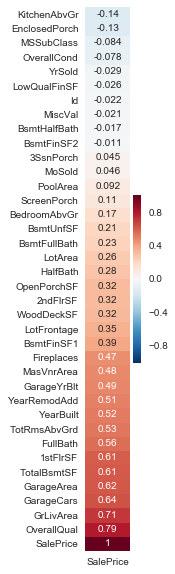

In [5]:
corrmat = df_train.corr()
indices = corrmat.loc[:,'SalePrice'].copy()
a = pd.DataFrame(indices.sort_values())
plt.figure(figsize=(1,10))
sns.heatmap(a, annot=True)

**Show me some plots**

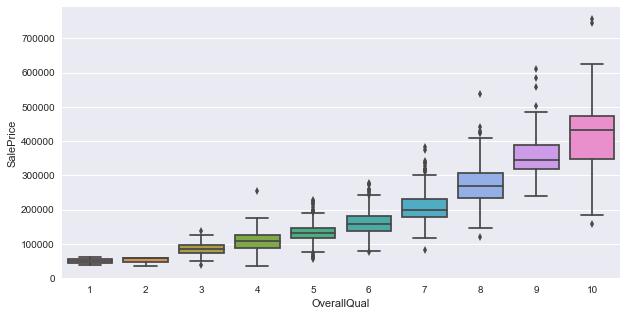

In [6]:
# box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_initial_train['SalePrice'], df_initial_train[var]], axis=1)
plt.figure(figsize=(10,5))
sns.boxplot(x=var, y="SalePrice", data=data)


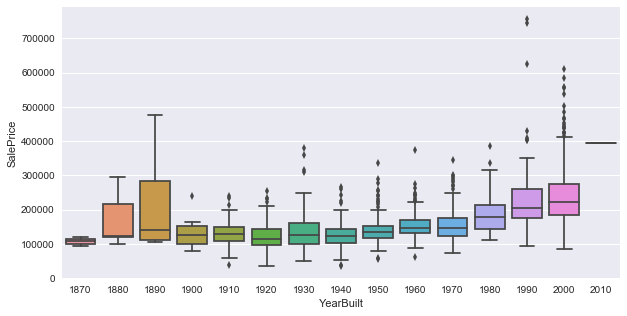

In [7]:
# box plot build decade/saleprice
var = 'YearBuilt'
data = pd.concat([df_initial_train['SalePrice'], (df_initial_train[var]//10)*10], axis=1)
plt.figure(figsize=(10,5))
sns.boxplot(x=var, y="SalePrice", data=data)

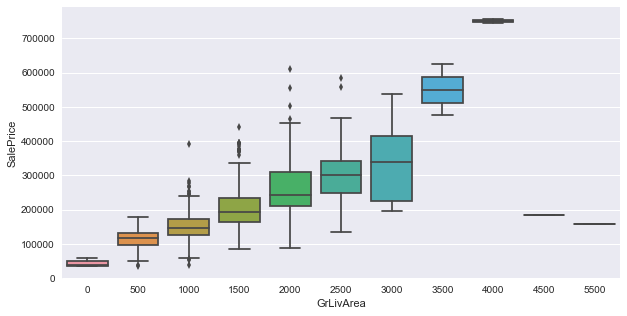

In [8]:
# box plot Ground Living Area/saleprice
var = 'GrLivArea'
data = pd.concat([df_initial_train['SalePrice'], (df_initial_train[var]//500)*500], axis=1)
plt.figure(figsize=(10,5))
sns.boxplot(x=var, y="SalePrice", data=data)

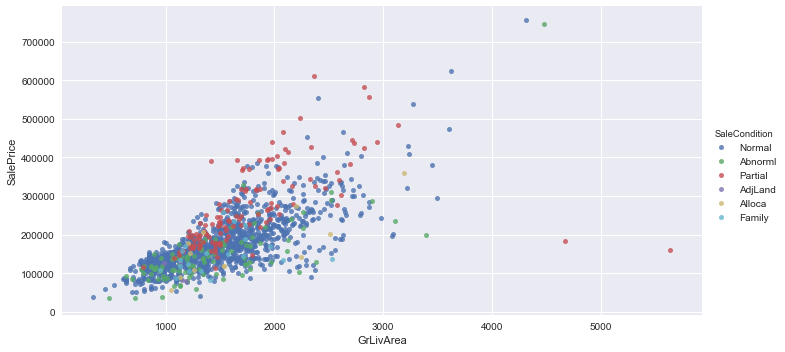

In [9]:
# scatter plot GrLivArea/saleprice
var = 'GrLivArea'
hue = 'SaleCondition'
data = pd.concat([df_initial_train['SalePrice'], df_initial_train[var], df_initial_train[hue]], axis=1)
sns.lmplot(x=var, y="SalePrice", data=data, fit_reg=False, hue=hue, aspect=2, size=5, scatter_kws={"s": 25})

**Which columns have nulls**

In [10]:
any_nulls = pd.DataFrame(df_train.isnull().sum())
any_nulls = any_nulls[any_nulls>0].dropna()

In [11]:
any_nulls

,0
Alley,2721.0
BsmtCond,82.0
BsmtExposure,82.0
BsmtFinSF1,1.0
BsmtFinSF2,1.0
BsmtFinType1,79.0
BsmtFinType2,80.0
BsmtFullBath,2.0
BsmtHalfBath,2.0
BsmtQual,81.0


**Convert Nulls**

In [12]:
# Change Lot Frontage from NA to 0
df_train.loc[:, "LotFrontage"] = df_train.loc[:, "LotFrontage"].fillna(0)
# Change Alley from NA to None
df_train.loc[:, "Alley"] = df_train.loc[:, "Alley"].fillna("None")
# Change Masonry veneer type from NA to None
df_train.loc[:, "MasVnrType"] = df_train.loc[:, "MasVnrType"].fillna("None")
# Change Masonry veneer area from NA to 0
df_train.loc[:, "MasVnrArea"] = df_train.loc[:, "MasVnrArea"].fillna(0)
# Change 333 Basement Finish Type 2 to Unf (same as Type 1)
df_train.loc[332, "BsmtFinType2"] = 'Unf'
# Change Basement Quality from NaN to None
df_train.loc[:, "BsmtQual"] = df_train.loc[:, "BsmtQual"].fillna("None")
# Change Basement Condition from NaN to None
df_train.loc[:, "BsmtCond"] = df_train.loc[:, "BsmtCond"].fillna("None")
# Change Basement Finish Type 1 and 2 from NaN to None
df_train.loc[:, "BsmtFinType1"] = df_train.loc[:, "BsmtFinType1"].fillna("None")
df_train.loc[:, "BsmtFinType2"] = df_train.loc[:, "BsmtFinType2"].fillna("None")
# Change Basement Exposure from NaN to None
df_train.loc[:, "BsmtExposure"] = df_train.loc[:, "BsmtExposure"].fillna("None")
# Change Fireplace Quality from NaN to None
df_train.loc[:, "FireplaceQu"] = df_train.loc[:, "FireplaceQu"].fillna("None")
# Change Garage Type from NaN to None
df_train.loc[:, "GarageType"] = df_train.loc[:, "GarageType"].fillna("None")
# Change Garage Finish from NaN to None
df_train.loc[:, "GarageFinish"] = df_train.loc[:, "GarageFinish"].fillna("None")
# Change Garage Quality from NaN to None
df_train.loc[:, "GarageQual"] = df_train.loc[:, "GarageQual"].fillna("None")
# Change Garage Condition from NaN to None
df_train.loc[:, "GarageCond"] = df_train.loc[:, "GarageCond"].fillna("None")
# Change Pool Quality from NaN to None
df_train.loc[:, "PoolQC"] = df_train.loc[:, "PoolQC"].fillna("None")
# Change Fence from NaN to None
df_train.loc[:, "Fence"] = df_train.loc[:, "Fence"].fillna("None")
# Change Misc Feature from NaN to None
df_train.loc[:, "MiscFeature"] = df_train.loc[:, "MiscFeature"].fillna("None")
# Change Garage Year built to same as Year Built
df_train.loc[:, "GarageYrBlt"] = df_train.loc[:, "GarageYrBlt"].fillna(df_train['YearBuilt'])

# Additional required for test data
# Change MSZoning from NaN to RL (most common)
df_train.loc[:, "MSZoning"] = df_train.loc[:, "MSZoning"].fillna("RL")
# Change Utilities from NaN to AllPub (most common)
df_train.loc[:, "Utilities"] = df_train.loc[:, "Utilities"].fillna("AllPub")
# Change basement NaN to 0 as its all for one record
df_train.loc[:, "BsmtFinSF1"] = df_train.loc[:, "BsmtFinSF1"].fillna(0)
df_train.loc[:, "BsmtFinSF2"] = df_train.loc[:, "BsmtFinSF2"].fillna(0)
df_train.loc[:, "BsmtUnfSF"] = df_train.loc[:, "BsmtUnfSF"].fillna(0)
df_train.loc[:, "TotalBsmtSF"] = df_train.loc[:, "TotalBsmtSF"].fillna(0)
df_train.loc[:, "BsmtFullBath"] = df_train.loc[:, "BsmtFullBath"].fillna(0)
df_train.loc[:, "BsmtHalfBath"] = df_train.loc[:, "BsmtHalfBath"].fillna(0)
# Change Siding from NaN to VinylSd as its the most common
df_train.loc[:, "Exterior1st"] = df_train.loc[:, "Exterior1st"].fillna("VinylSd")
df_train.loc[:, "Exterior2nd"] = df_train.loc[:, "Exterior2nd"].fillna("VinylSd")
# Change KitchenQual from NaN to TA as its the most common
df_train.loc[:, "KitchenQual"] = df_train.loc[:, "KitchenQual"].fillna("TA")
# Change Functional from NaN to Typ as its the most common
df_train.loc[:, "Functional"] = df_train.loc[:, "Functional"].fillna("Typ")
# Change Garage from NaN to the mean
df_train.loc[:, "GarageCars"] = df_train.loc[:, "GarageCars"].fillna(df_train['GarageCars'].mean())
df_train.loc[:, "GarageArea"] = df_train.loc[:, "GarageArea"].fillna(df_train['GarageArea'].mean())
# Change SaleType from NaN to WD as its the most common
df_train.loc[:, "SaleType"] = df_train.loc[:, "SaleType"].fillna("WD")

**Convert categorical features to strings**

From *A study on Regression applied to the Ames dataset*

In [13]:
df_train = df_train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                                 "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                       7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                            })

**Make "exists" features**

In [14]:
exists_features = ({"Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 1},
                       "BsmtCond" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       # always 1 "ExterCond" : {"None" : 0, "Po" : 1, "Fa" : 1, "TA": 1, "Gd": 1, "Ex" : 1},
                       "FireplaceQu" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       "GarageQual" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       # always 1 "HeatingQC" : {"None" : 0, "Po" : 1, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       "PavedDrive" : {"N" : 0, "P" : 0, "Y" : 1},
                       "PoolQC" : {"None" : 0, "No" : 0, "Fa" : 1, "TA" : 1, "Gd" : 1, "Ex" : 1},
                       "Street" : {"Grvl" : 0, "Pave" : 1},
                       "MasVnrType" : {"None" : 0, "BrkCmn" : 1, "BrkFace" : 1, "Stone" : 1},
                       "Fence" : {"None" : 0, "GdPrv" : 1, "MnPrv" : 1, "GdWo" : 1, "MnWw" : 1},
                       "CentralAir" : {"N" : 0, "Y" : 1},
                       "MiscFeature" : {"None" : 0, "Shed" : 1, "Othr" : 1, "Gar2" : 1, "Tenc" : 1, "Elev" : 1}}
                     )

for key, value in exists_features.items():
    new_col_name = key+"_exists"
    df_train[new_col_name] = df_train[key].replace(value)

**Make features ordered**

From *A study on Regression applied to the Ames dataset* - added "None" and MasVnrType

In [15]:
ordered_features = ({"Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0, "No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
                       "MasVnrType" : {"None" : 0, "BrkCmn" : 1, "BrkFace" : 2, "Stone" : 3}}
                     )

for key, value in ordered_features.items():
    new_col_name = key+'_orig'
    df_train[new_col_name] = df_train[key]

for key, value in ordered_features.items():
    new_col_name = key
    df_train[new_col_name] = df_train[key].replace(value)

**Other engineered features**

In [16]:
# Total house bathrooms
df_train["TotalBathrooms"] = df_train["BsmtFullBath"] + df_train["BsmtHalfBath"] + df_train["FullBath"] + df_train["HalfBath"]
# Total house rooms
df_train["TotalHouseRooms"] = df_train["TotalBathrooms"] + df_train["TotRmsAbvGrd"]
# Total house square footage
df_train["TotalHouseSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"]
# Total house plus basement
df_train["TotalHouseBsmtSF"] = df_train["TotalHouseSF"] + df_train["TotalBsmtSF"]
# Average room size
df_train["AvgRoomSize"] = df_train["TotalHouseRooms"] + df_train["TotalHouseBsmtSF"]
# Had a remodel
df_train["Remodled"] = df_train["YearRemodAdd"]>df_train["YearBuilt"]
df_train["Remodled"] = df_train["Remodled"].apply(lambda x: 1 if x else 0)
# Has a deck
df_train["WoodDeckSF_exists"] = df_train["WoodDeckSF"] > 0
df_train["WoodDeckSF_exists"] = df_train["WoodDeckSF_exists"].apply(lambda x: 1 if x else 0)
df_train["OpenPorchSF_exists"] = df_train["OpenPorchSF"] > 0
df_train["OpenPorchSF_exists"] = df_train["OpenPorchSF_exists"].apply(lambda x: 1 if x else 0)
df_train["EnclosedPorch_exists"] = df_train["EnclosedPorch"] > 0
df_train["EnclosedPorch_exists"] = df_train["EnclosedPorch_exists"].apply(lambda x: 1 if x else 0)
df_train["3SsnPorch_exists"] = df_train["3SsnPorch"] > 0
df_train["3SsnPorch_exists"] = df_train["3SsnPorch_exists"].apply(lambda x: 1 if x else 0)
df_train["ScreenPorch_exists"] = df_train["ScreenPorch"] > 0
df_train["ScreenPorch_exists"] = df_train["ScreenPorch_exists"].apply(lambda x: 1 if x else 0)
# Deck area
df_train["Deck_area"] = (df_train["WoodDeckSF"] + df_train["OpenPorchSF"] + df_train["EnclosedPorch"] 
                         + df_train["3SsnPorch"] +df_train["ScreenPorch"])
# Neighborhood comparison
neighborhood_means = df_train.groupby(["Neighborhood"]).mean()
# Lot Area SF compared to neighbohood
df_train["LotArea_Neighborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"LotArea"])
df_train["LotArea_Neighborhood"]= (df_train["LotArea"] - df_train["LotArea_Neighborhood"])/df_train["LotArea_Neighborhood"]
# House + Basement SF compared to neighbohood
df_train["TotalHouseBsmtSF_Neighborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"TotalHouseBsmtSF"])
df_train["TotalHouseBsmtSF_Neighborhood"]= (df_train["TotalHouseBsmtSF"] - df_train["TotalHouseBsmtSF_Neighborhood"])/df_train["TotalHouseBsmtSF_Neighborhood"]
# House + Basement SF compared to neighbohood
df_train["TotalHouseSF_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"TotalHouseSF"])
df_train["TotalHouseSF_Neigborhood"]= (df_train["TotalHouseSF"] - df_train["TotalHouseSF_Neigborhood"])/df_train["TotalHouseSF_Neigborhood"]
# Age of house vs Neighborhood
df_train["YearBuilt_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"YearBuilt"])
df_train["YearBuilt_Neigborhood"]= (df_train["YearBuilt"] - df_train["YearBuilt_Neigborhood"])/df_train["YearBuilt_Neigborhood"]
# Age of renovation vs Neighborhood
df_train["YearRemodAdd_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"YearRemodAdd"])
df_train["YearRemodAdd_Neigborhood"]= (df_train["YearRemodAdd"] - df_train["YearRemodAdd_Neigborhood"])/df_train["YearRemodAdd_Neigborhood"]
# Overall Quality vs Neighborhood
df_train["OverallQual_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"OverallQual"])
df_train["OverallQual_Neigborhood"]= (df_train["OverallQual"] - df_train["OverallQual_Neigborhood"])/df_train["OverallQual_Neigborhood"]
# Overall Condition vs Neighborhood
df_train["OverallCond_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"OverallCond"])
df_train["OverallCond_Neigborhood"]= (df_train["OverallCond"] - df_train["OverallCond_Neigborhood"])/df_train["OverallCond_Neigborhood"]
# Heating Quality vs Neighborhood
df_train["HeatingQC_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"HeatingQC"])
df_train["HeatingQC_Neigborhood"]= (df_train["HeatingQC"] - df_train["HeatingQC_Neigborhood"])/df_train["HeatingQC_Neigborhood"]
# Lot Shape vs Neighborhood
df_train["LotShape_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"LotShape"])
df_train["LotShape_Neigborhood"]= (df_train["LotShape"] - df_train["LotShape_Neigborhood"])/df_train["LotShape_Neigborhood"]
# Kitchen Quality vs Neighborhood
df_train["KitchenQual_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"KitchenQual"])
df_train["KitchenQual_Neigborhood"]= (df_train["KitchenQual"] - df_train["KitchenQual_Neigborhood"])/df_train["KitchenQual_Neigborhood"]
# Exterior Quality vs Neighborhood
df_train["ExterQual_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"ExterQual"])
df_train["ExterQual_Neigborhood"]= (df_train["ExterQual"] - df_train["ExterQual_Neigborhood"])/df_train["ExterQual_Neigborhood"]
# Room size vs Neighborhood
df_train["AvgRoomSize_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"AvgRoomSize"])
df_train["AvgRoomSize_Neigborhood"]= (df_train["AvgRoomSize"] - df_train["AvgRoomSize_Neigborhood"])/df_train["AvgRoomSize_Neigborhood"]

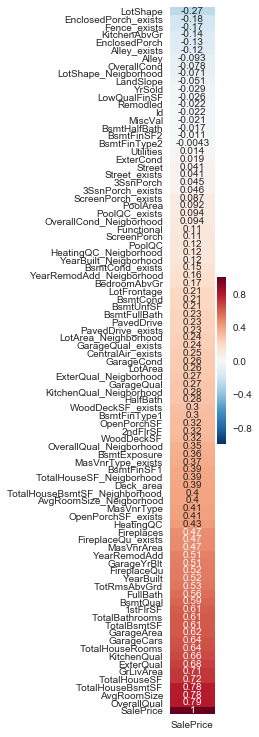

In [17]:
corrmat = df_train.corr()
indices = corrmat.loc[:,'SalePrice'].copy()
a = pd.DataFrame(indices.sort_values())
plt.figure(figsize=(1,13))
sns.heatmap(a, annot=True)

**Drop crappy data**

Tried including more SaleTypes and Saleconditions but normal seemed to work better

In [18]:
# Drop 949 as has a basement but NA for exposure
df_train.drop(948, inplace=True)
# Drop 1380 as no electrical
df_train.drop(1379, inplace=True)
# Drop those entries that have lot area larger than 100000ft (but keep all "test" data)
df_train = df_train[(df_train['LotArea'] < 100000) | (df_train['Id'].isin(df_test["Id"]))]
# Drop those entries that have lot frontage larger than 300ft (but keep all "test" data)
#df_train = df_train[(df_train['LotFrontage'] < 300) | (df_train['Id'].isin(df_test["Id"]))]
# Only include sales where house is in normal condition (but keep all "test" data)
df_train = df_train[(df_train['SaleCondition'] == 'Normal') | (df_train['Id'].isin(df_test["Id"]))]
# Only include conventional sales(but keep all "test" data)
df_train = df_train[(df_train['SaleType'] == 'WD') | (df_train['Id'].isin(df_test["Id"]))]

**Drop other features**

In [19]:
# Drop MiscVal as it contains different types of data
df_train.drop('MiscVal', axis=1, inplace=True)
# Add target variable and drop Sale Price
y_SalePrice = pd.DataFrame(df_train['SalePrice'], columns=['SalePrice']).dropna().copy()
df_train.drop('SalePrice', axis=1, inplace=True)

**Remove skewness in numeric features**

In [20]:
# Get numeric features of current df_train
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index

# Update columns with log1p if skewness  .1
skewed = df_train[numeric_feats].apply(lambda x: abs(stats.skew(x.dropna()))) #compute skewness
# drop Id column
skewed = skewed.drop(['Id'])
skewed_feats = skewed[(skewed>.1)].index

# Tried with Box-Cox but it didn't improve
#df_train[skewed_feats] = boxcox1p(df_train[skewed_feats], .2)
#y_SalePrice,boxcoxlambda = stats.boxcox(y_SalePrice+1)

df_train[skewed_feats] = np.log1p(df_train[skewed_feats])

y_SalePrice = np.log1p(y_SalePrice)

**Get dummies for categorical features**

In [21]:
cat_feats = df_train.dtypes[df_train.dtypes == "object"].index

df_train_cat = pd.get_dummies(df_train.loc[:,cat_feats])
df_train_num = df_train.loc[:,numeric_feats].copy()
df_train = pd.concat([df_train_num,df_train_cat], axis=1)

**Create new Polynomials on some top existing features**

Am I meant to create these before or after normalizing?

In [22]:
# Create new features
# 3* Polynomials on the top 10 existing features
df_train["OverallQual-s2"] = df_train["OverallQual"] ** 2
df_train["OverallQual-s3"] = df_train["OverallQual"] ** 3
df_train["OverallQual-Sq"] = np.sqrt(df_train["OverallQual"])
df_train["TotalHouseBsmtSF-2"] = df_train["TotalHouseBsmtSF"] ** 2
df_train["TotalHouseBsmtSF-3"] = df_train["TotalHouseBsmtSF"] ** 3
df_train["TotalHouseBsmtSF-Sq"] = np.sqrt(df_train["TotalHouseBsmtSF"])
df_train["TotalHouseSF-2"] = df_train["TotalHouseSF"] ** 2
df_train["TotalHouseSF-3"] = df_train["TotalHouseSF"] ** 3
df_train["TotalHouseSF-Sq"] = np.sqrt(df_train["TotalHouseSF"])
df_train["GrLivArea-2"] = df_train["GrLivArea"] ** 2
df_train["GrLivArea-3"] = df_train["GrLivArea"] ** 3
df_train["GrLivArea-Sq"] = np.sqrt(df_train["GrLivArea"])
df_train["ExterQual-2"] = df_train["ExterQual"] ** 2
df_train["ExterQual-3"] = df_train["ExterQual"] ** 3
df_train["ExterQual-Sq"] = np.sqrt(df_train["ExterQual"])
df_train["GarageCars-2"] = df_train["GarageCars"] ** 2
df_train["GarageCars-3"] = df_train["GarageCars"] ** 3
df_train["GarageCars-Sq"] = np.sqrt(df_train["GarageCars"])
df_train["KitchenQual-2"] = df_train["KitchenQual"] ** 2
df_train["KitchenQual-3"] = df_train["KitchenQual"] ** 3
df_train["KitchenQual-Sq"] = np.sqrt(df_train["KitchenQual"])
df_train["TotalBsmtSF-2"] = df_train["TotalBsmtSF"] ** 2
df_train["TotalBsmtSF-3"] = df_train["TotalBsmtSF"] ** 3
df_train["TotalBsmtSF-Sq"] = np.sqrt(df_train["TotalBsmtSF"])
df_train["AvgRoomSize-2"] = df_train["AvgRoomSize"] ** 2
df_train["AvgRoomSize-3"] = df_train["AvgRoomSize"] ** 3
df_train["AvgRoomSize-Sq"] = np.sqrt(df_train["AvgRoomSize"])

In [23]:
# Add some "a*b" features
df_train['OverallQual_TotalHouseBsmtSF'] = df_train["OverallQual"] * df_train["TotalHouseBsmtSF"]
df_train['OverallQual_GrLivArea'] = df_train["OverallQual"] * df_train["GrLivArea"]
df_train['OverallQual_KitchenQual'] = df_train["OverallQual"] * df_train["KitchenQual"]
df_train['OverallQual_OverallCond'] = df_train["OverallQual"] * df_train["OverallCond"]
df_train['TotalHouseBsmtSF_GarageCars'] = df_train["GarageCars"] * df_train["TotalHouseBsmtSF"]
df_train['OverallQual_ExterQual'] = df_train["OverallQual"] * df_train["ExterQual"]
df_train['LotArea_TotalHouseBsmtSF'] = df_train["LotArea"] * df_train["TotalHouseBsmtSF"]
df_train['KitchenQual_TotalHouseBsmtSF'] = df_train["KitchenQual"] * df_train["TotalHouseBsmtSF"]
df_train["TotalBathrooms_TotalHouseBsmtSF"] = df_train["TotalBathrooms"] * df_train["TotalHouseBsmtSF"]
df_train["TotalHouseRooms_TotalHouseBsmtSF"] = df_train["TotalHouseRooms"] * df_train["TotalHouseBsmtSF"]
df_train['OverallQual_AvgRoomSize'] = df_train["OverallQual"] * df_train["AvgRoomSize"]
df_train['OverallCond_AvgRoomSize'] = df_train["OverallCond"] * df_train["AvgRoomSize"]
df_train['OverallQual_TotalBathrooms'] = df_train["OverallQual"] * df_train["TotalBathrooms"]
df_train['OverallCond_TotalBathrooms'] = df_train["OverallCond"] * df_train["TotalBathrooms"]
df_train['OverallQual_TotalBathrooms'] = df_train["OverallQual"] * df_train["HeatingQC"]
df_train['OverallCond_TotalBathrooms'] = df_train["OverallCond"] * df_train["HeatingQC"]
df_train['OverallQual_LandSlope'] = df_train["OverallQual"] * df_train["LandSlope"]
df_train['OverallCond_LandSlope'] = df_train["OverallCond"] * df_train["LandSlope"]

**Split out the testing and training data again**

In [24]:
df_test = df_train[df_train['Id'].isin(df_test['Id'])].copy()
df_train = df_train[df_train['Id'].isin(df_initial_train['Id'])]

**Scaled dataframe**

In [25]:
# Scale the numerical features to create a scaled df for SelectFromModel
scaler = RobustScaler()
df_train_scaled = df_train.copy()
df_train_scaled.loc[:,:] = scaler.fit_transform(df_train.loc[:,:])

**Define some functions to help with predictions**

Borrowed from some of this from *A study on Regression applied to the Ames dataset*

In [26]:
def format_good_features(good_feats, df):
    #Format the Dataframe with only the good features selected from the SelectFromModel
    
    good_feats_index = good_feats.get_support()
    good_feats_columns = df.columns[good_feats_index]
    
    return df.loc[:,good_feats_columns]

In [27]:
def split_scale(X, y, scaler_function=RobustScaler()):
    # train_test_split then scale the features  
    
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.3, random_state=42)

    scaler2 = scaler_function
    X_train.loc[:,:] = scaler2.fit_transform(X_train.loc[:,:])
    X_test.loc[:,:] = scaler2.fit_transform(X_test.loc[:,:])
    
    return X_train, X_test, y_train, y_test

In [28]:
def centered_alpha(alpha):
    # Get new alphas for testing centered around previous best alpha
    
    return np.ravel([alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, alpha * .95, 
              alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4])

In [29]:
def output_findings(model, name, df_train, y_test, y_train, column_name, y_train_model, y_test_model):
    # Output a plot of important coefficients and show the RMSE for the training and test data
    
    # Plot important coefficients
    coefs = pd.Series(np.ravel(model.coef_), index = np.ravel(df_train.columns))
    print(name + " picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
          str(sum(coefs == 0)) + " features")
    imp_coefs = pd.concat([coefs.sort_values().head(10),
                         coefs.sort_values().tail(10)])
    imp_coefs.plot(kind = "barh")
    plt.title("Coefficients in the "+ name + " Model")
    plt.show()

    #Show RMSE
    print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(np.expm1(y_train)),
                                                           np.log1p(np.expm1(y_train_model)))))
    print("RMSE Testing Data: ",np.sqrt(mean_squared_error(np.log1p(np.expm1(y_test)),
                                                           np.log1p(np.expm1(y_test_model)))))
    #Tried box-cox but didnt improve
    #print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(inv_boxcox1p(y_train,boxcoxlambda)),
    #                                                       np.log1p(inv_boxcox1p(y_train_model,boxcoxlambda)))))
    #print("RMSE Testing Data: ",np.sqrt(mean_squared_error(np.log1p(inv_boxcox1p(y_test,boxcoxlambda)),
    #                                                       np.log1p(inv_boxcox1p(y_test_model,boxcoxlambda)))))

**RidgeCV**

Best alpha : 10
Try again for more precision with alphas centered around 10
Best alpha : 13.5
RidgeCV picked 280 features and eliminated the other 3 features


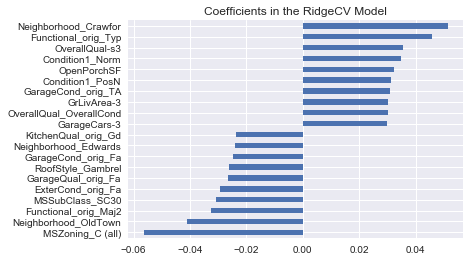

RMSE Training Data: 0.0730392239714
RMSE Testing Data:  0.0953287317282


In [52]:
# Set initial variables
alphas = [.3, 1, 2, 5, 10, 100]
cv = KFold(20,True,42)
gcv_mode = 'auto'
scoring = 'neg_mean_squared_error'

#Features based on SelectFromModel(RidgeCV)
clf = RidgeCV(alphas = alphas, cv=cv, gcv_mode=gcv_mode, scoring=scoring)
good_feats_ridge = SelectFromModel(clf,threshold=".4*mean").fit(df_train_scaled,y_SalePrice)

# Format training data
df_train_ridge = format_good_features(good_feats_ridge, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_ridge, y_SalePrice, scaler_function=RobustScaler())

# Run RidgeCV to find best alphas
ridge = RidgeCV(alphas = alphas, cv=cv, gcv_mode=gcv_mode, scoring=scoring)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

# Get even better alphas
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = centered_alpha(alpha), cv = cv, gcv_mode=gcv_mode, scoring=scoring)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

# Run predictions
y_train_ridge = ridge.predict(X_train)
y_test_ridge = ridge.predict(X_test)

# Output findings
output_findings(ridge, "RidgeCV", df_train_ridge, y_test, y_train, "SalePrice", y_train_ridge, y_test_ridge)


**LassoCV**

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 0.000115
LassoCV picked 123 features and eliminated the other 22 features


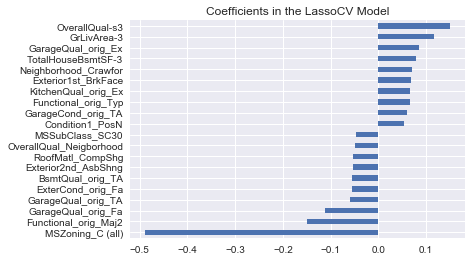

RMSE Training Data: 0.0674960476427
RMSE Testing Data:  0.0960581777678


In [31]:
# Set initial variables
alphas = [.00001, .00003, .0001, .0003]
max_iter = 15000
cv = KFold(10,True,42)

#Features based on SelectFromModel(LassoCV)
clf = LassoCV(alphas = np.ravel(alphas), max_iter = max_iter, cv = cv)
good_feats_lasso = SelectFromModel(clf,threshold=".005*mean").fit(df_train_scaled,np.ravel(y_SalePrice))

# Format training data
df_train_lasso = format_good_features(good_feats_lasso, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_lasso, y_SalePrice)

# Run LassoCV to find best alphas
lasso = LassoCV(alphas = np.ravel(alphas), max_iter = max_iter, cv = cv)
lasso.fit(X_train, np.ravel(y_train))
alpha = lasso.alpha_
print("Best alpha :", alpha)

# Get even better alphas
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = np.ravel(centered_alpha(alpha)), max_iter = max_iter, cv = cv)
lasso.fit(X_train, np.ravel(y_train))
alpha = lasso.alpha_
print("Best alpha :", alpha)

# Run predictions
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)

# Output findings
output_findings(lasso, "LassoCV", df_train_lasso, y_test, y_train, "SalePrice", y_train_lasso, y_test_lasso)

**ElasticNetCV**

# Set initial variables
alphas = np.ravel([.0001, .0003, .001, .003, .01])
max_iter = 15000
cv = KFold(10,True,42)
l1_ratio = [.003, .01, .03, .1, .3]

#Features based on SelectFromModel(ElasticNetCV)
clf = ElasticNetCV(alphas = np.ravel(alphas), max_iter = max_iter, cv = cv, l1_ratio=l1_ratio)
good_feats_elas = SelectFromModel(clf,threshold=".005*mean").fit(df_train_scaled,np.ravel(y_SalePrice))

# Format training data
df_train_elas = format_good_features(good_feats_elas, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_elas, y_SalePrice)

# Run ElasticNetCV to find best alphas and ratio
elas = ElasticNetCV(alphas = np.ravel(alphas), max_iter = max_iter, cv = cv, l1_ratio=l1_ratio)
elas.fit(X_train, np.ravel(y_train))
alpha = elas.alpha_
ratio = elas.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

# Get even better alphas
print("Try again for more precision with alphas centered around " + str(alpha))
elas = ElasticNetCV(alphas = np.ravel(centered_alpha(alpha)), max_iter = max_iter, cv = cv, l1_ratio=ratio)
elas.fit(X_train, np.ravel(y_train))
alpha = elas.alpha_
ratio = elas.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha)

# Run predictions
y_train_elas = elas.predict(X_train)
y_test_elas = elas.predict(X_test)

# Output findings
output_findings(elas, "ElasticNetCV", df_train_elas, y_test, y_train, "SalePrice", y_train_elas, y_test_elas)

**BayesianRidge**

Convergence after  14  iterations
BayesianRidge picked 281 features and eliminated the other 0 features


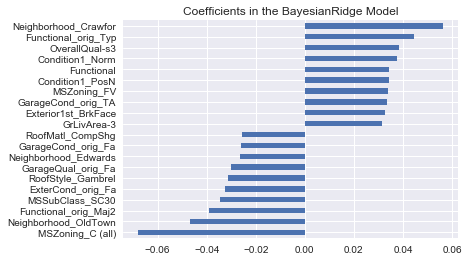

RMSE Training Data: 0.0716027925754
RMSE Testing Data:  0.0965984572166


In [50]:
# Set initial variables
n_iter = 300

#Features based on SelectFromModel(BayesianRidge)
clf = BayesianRidge(n_iter = n_iter)
good_feats_bayes = SelectFromModel(clf,threshold=".4*mean").fit(df_train_scaled,np.ravel(y_SalePrice))

# Format training data
df_train_bayes = format_good_features(good_feats_bayes, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_bayes, y_SalePrice)

# Run BayesianRidge (ran some tests to find best alpha - changing it had no impact)
bayes = BayesianRidge(n_iter = n_iter, verbose=True)
bayes.fit(X_train, np.ravel(y_train))

# Run predictions
y_train_bayes = bayes.predict(X_train)
y_test_bayes = bayes.predict(X_test)

# Output findings
output_findings(bayes, "BayesianRidge", df_train_bayes, y_test, y_train, "SalePrice", y_train_bayes, y_test_bayes)

**RandomForestRegressor**


RandomForestRegressor picked 285 features and eliminated the other 0 features


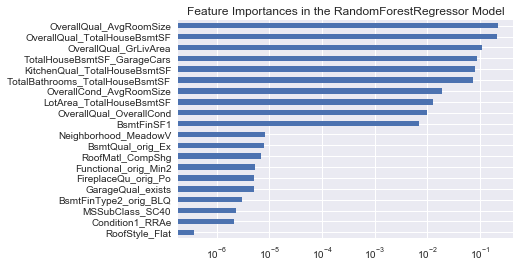

RMSE Training Data: 0.00336772781464
RMSE Testing Data: 0.00940831420626


In [33]:
# Set initial variables
n_estimators = 200

#Features based on SelectFromModel(RandomForestRegressor)
clf = RandomForestRegressor(n_estimators=n_estimators)
good_feats_rfr = SelectFromModel(clf,threshold=".01*mean").fit(df_train_scaled,np.ravel(y_SalePrice))

# Format training data
df_train_rfr = format_good_features(good_feats_rfr, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_rfr, y_SalePrice)

# Run RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=n_estimators)
rfr.fit(X_train, np.ravel(y_train))

# Run predictions
y_train_rfr = rfr.predict(X_train)
y_test_rfr = rfr.predict(X_test)

# Output findings - cant use function as this uses .feature_importances_ rather than coefs_
# Plot important coefficients
coefs = pd.Series(rfr.feature_importances_, index = df_train_rfr.columns)
print("RandomForestRegressor picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
coefs = coefs[coefs !=0]
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Feature Importances in the RandomForestRegressor Model")
plt.xscale('log')
plt.show()

# Show RSME
print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(y_train),np.log1p(y_train_rfr))))
print("RMSE Testing Data:",np.sqrt(mean_squared_error(np.log1p(y_test),np.log1p(y_test_rfr))))

# Predictions from each model

In [34]:
def get_predictions(model, filename, good_features, df):
    # Get right features
    df_model_test = format_good_features(good_features, df)
    # Scale the features
    scaler2 = RobustScaler()
    df_model_test.loc[:,:] = scaler2.fit_transform(df_model_test.loc[:,:])
    # Predict
    predictions = model.predict(df_model_test)
    predictions = pd.DataFrame(predictions, index=df['Id'], columns=['SalePrice'])
    # Get real prices and save to csv
    predictions = np.expm1(predictions)
    predictions.to_csv(filename, index_label='Id')
    return predictions

In [35]:
def mean_of_models(models, filename, index):
    mean_model = pd.concat(models, axis=1)
    mean_model = mean_model.mean(axis=1)
    test_mean = pd.DataFrame(mean_model, index=index, columns=['SalePrice'])
    test_mean.to_csv(filename, index_label='Id')
    return test_mean

**Ridge**

In [54]:
test_ridge = get_predictions(ridge, 'test_ridge.csv', good_feats_ridge, df_test)

**Lasso**

In [37]:
test_lasso = get_predictions(lasso, 'test_lasso.csv', good_feats_lasso, df_test)

**ElasticNet**

In [38]:
#test_elas = get_predictions(elas, 'test_elas.csv', good_feats_elas, df_test)

NameError: name 'elas' is not defined

**BayesianRidge**

In [51]:
test_bayes = get_predictions(bayes, 'test_bayes.csv', good_feats_bayes, df_test)

**RandomForestsRegressor**

In [41]:
test_rfr = get_predictions(rfr, 'test_rfr.csv', good_feats_rfr, df_test)

**Mean of all models**

In [42]:
# Mean difference of model from mean of all models
differ = pd.concat([test_bayes, test_elas, test_ridge, test_lasso, test_rfr], axis=1)
differ.set_axis(1, ['test_bayes', 'test_elas', 'test_ridge', 'test_lasso', 'test_rfr'])
differ['mean'] = differ.mean(axis=1)
differ['diff_bayes'] = (differ.loc[:,'mean'] - differ.loc[:,'test_bayes']) / differ.loc[:,'test_bayes']
differ['diff_elas'] = (differ.loc[:,'mean'] - differ.loc[:,'test_elas']) / differ.loc[:,'test_elas']
differ['diff_ridge'] = (differ.loc[:,'mean'] - differ.loc[:,'test_ridge']) / differ.loc[:,'test_ridge']
differ['diff_lasso'] = (differ.loc[:,'mean'] - differ.loc[:,'test_lasso']) / differ.loc[:,'test_lasso']
differ['diff_rfr'] = (differ.loc[:,'mean'] - differ.loc[:,'test_rfr']) / differ.loc[:,'test_rfr']

# some stats on the models
absdiff = differ.abs().mean()[-5:]
avgdiff = differ.mean()[-5:]
stddiff = differ.std()[-5:]
ltdiff = differ.iloc[:,-5:][differ.iloc[:,-5:]<0].count()
gtdiff = differ.iloc[:,-5:][differ.iloc[:,-5:]>0].count()
avgltdiff = differ.iloc[:,-5:][differ.iloc[:,-5:]<0].mean()
avggtdiff = differ.iloc[:,-5:][differ.iloc[:,-5:]>0].mean()

# Absolute Difference, Average Difference, Count less than mean, Count greater than mean, 
# Average of those less than mean, Average of those greater than mean
differ2 = pd.concat([absdiff, avgdiff, ltdiff, gtdiff, avgltdiff, avggtdiff], axis=1, 
                    keys=['absdiff', 'avgdiff', 'ltdiff', 'gtdiff', 'avgltdiff', 'avggtdiff'])
differ2

NameError: name 'test_elas' is not defined

In [ ]:
mean_of_models([test_bayes, test_elas, test_ridge, test_lasso, test_rfr], 'test_mean_all.csv', df_test['Id'])

In [55]:
# try some different combos
mean_of_models([test_bayes, test_ridge], 'test_mean_bayes_ridge.csv', df_test['Id'])

,SalePrice
Id,
1461,117666.865105
1462,167333.744380
1463,184740.675561
1464,204880.120894
1465,200840.540280
1466,173489.256842
1467,181691.078887
1468,169464.935229
1469,201245.585296
